# Imports

In [1]:
# 2. Font Recognition Pipeline.ipynb
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

from pipeline_helpers import preprocess_image, segment_characters, match_characters

/Users/yc/anaconda3/envs/Fontsfinder/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/yc/anaconda3/envs/Fontsfinder/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


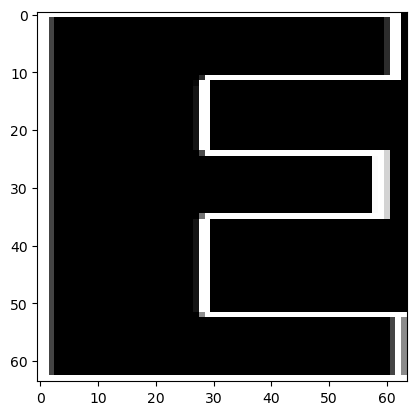

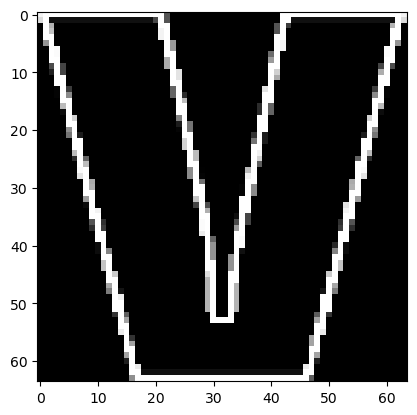

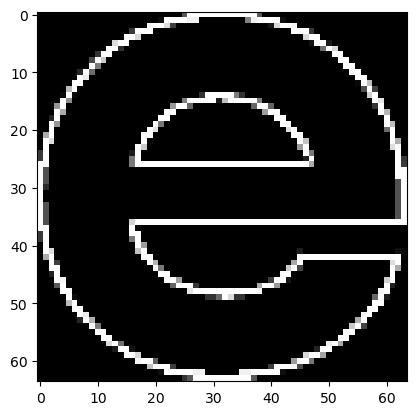

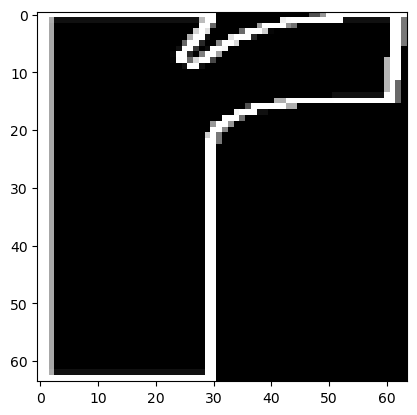

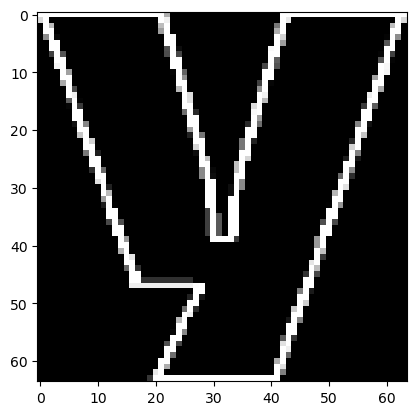

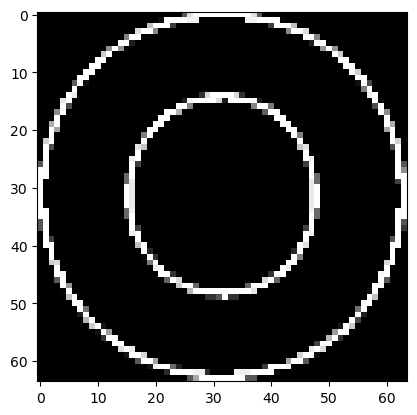

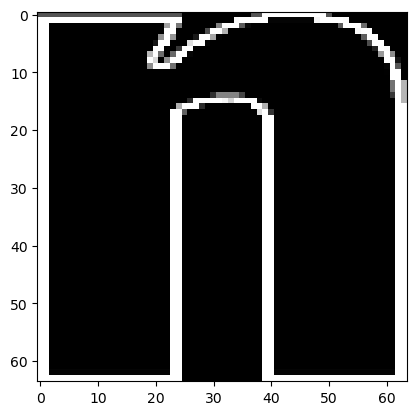

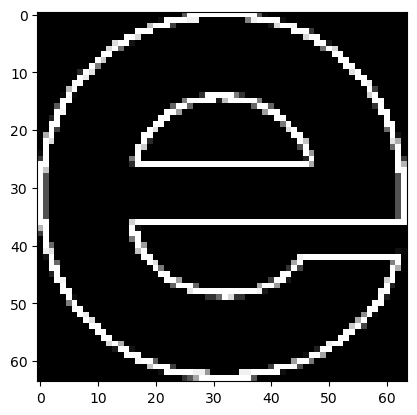

Detected text: Everyone


In [2]:
# Example usage
image_path = "../example_images/test.png"
processed = preprocess_image(image_path)
chars = segment_characters(processed)

# Verify characters with user input
detected_text = []
for i, char_img in enumerate(chars):
    plt.imshow(char_img, cmap='gray')
    plt.show()
    char = input(f"Enter character {i+1}: ")
    detected_text.append(char)

text = "".join(detected_text)
print("Detected text:", text)

In [3]:
import sqlite3
db_path = '../db/fonts.db'

with sqlite3.connect(db_path) as conn:
    c = conn.cursor()
    
    # Get the list of all tables
    c.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = c.fetchall()
    print("Tables in database:", tables)

    c.execute("SELECT * FROM characters LIMIT 5;")
    tables = c.fetchall()
    print("Tables in database:", tables)

    c.execute("SELECT * FROM fonts LIMIT 5;")
    tables = c.fetchall()
    print("Tables in database:", tables)

Tables in database: [('fonts',), ('characters',)]
Tables in database: [(1, '\x00', '../db/chars/1_0.svg', b'\x80\x80\xc3\xbf\x80x\xa4\xbf\x1eN-\xc0\x84\x8e<\xc0\xc2\xc7G\xbf\xa7eo\xc0\rQ-\xc0A\x8f\x8b\xbeP6\xd1\xbfZy\x1b@Aw\x1a@Q\x92\xee>%\xf5\'?\xa5<\x84?\xca\xab\xb8=\x9c\x8c\x96\xbf\xf9\xeeR@M\x99%\xc0\x8f\x9cU>b\xbeY?\x0fsi@\xaf\xe1\xab@C\xacP@"\r"@\xa2%\x8c\xbcn\xf5P\xbf_\xe39?+O\xa2\xbe\xdc\x95\x14\xc0\xca\xa8*\xc0\xb8\x88%\xc0\x1d=\x1d\xc0E\x04\xdc\xbf\x02G&\xc0\xfe|\xdc\xbfVX\x9a\xbf\xf6^\x02\xbd\x8b\x05\x03\xc0K\xe7\r@\xf2\xd0\xce\xbf\xfa4\xc6\xbe8\x8f\xa3>\xb7\xca1@1\xfd\xb2?\xaa\xbe\xc2\xbe"\xe2$?\xdb\xf5\xdd\xbf\xbf\xe9\xeb?cG5>\xab\xd9\xdc\xbe_\x00\xe9\xbf\xd4\xc5v\xbf\t0\x07?>\xac\x01\xbf\xef\xc5\xca\xbda\xb3\xaa\xbf\x97sO>\xb3O[\xbf%]\xe0?a\xd6\x14@\xa5z\x9a?\xa6\xb2\x87?rK\xbe?\xc2\xc4m@\xe0% @\xec\xab]\xbf\xc0\x8a\x18@\xa5\x87\x11?\xfd\xb8M@o][\xbf\x12\x91\x19\xc0L/\xf5\xbf}\x9e\x8f\xbe\xcan\xe5?\xae\xa0\x9f\xbf\xd8V\xaa\xbf\x9a\x19.\xc0\x00\xd2\x13\xbf\x9c\xca\xbd?=\xd

In [ ]:
from pipeline_helpers import *
from db_helpers import get_db_connection

def match_characters(char_img, char, db_path='../db/fonts.db'):
    """Thread-safe character matching with database connection handling"""
    features = get_cnn_features(char_img)
    matches = []
    
    # Use our thread-safe connection context manager
    with get_db_connection(db_path) as conn:
        c = conn.cursor()
        
        # First get all potential matches
        c.execute('''SELECT font_id, features_blob FROM characters 
                     WHERE char = ?''', (char,))
        
        # Process each match
        for font_id, features_blob in c.fetchall():
            print(c)
            if features_blob is None:
                print("is None")
                continue
                
            try:
                # Load and compare features
                db_features = np.frombuffer(features_blob, dtype=np.float32)
                print(db_features)
                # Reshape for sklearn's cosine_similarity
                features_2d = features.reshape(1, -1)
                db_features_2d = db_features.reshape(1, -1)
                
                similarity = cosine_similarity(features_2d, db_features_2d)[0][0]
                matches.append((font_id, similarity))
            except Exception as e:
                print(f"Error comparing features for font {font_id}: {str(e)}")
                continue
    
    return matches

In [ ]:
debug = False

# Then in your main processing loop:
font_scores = {}

for char_img, char in zip(chars, detected_text):
    char_matches = match_characters(char_img, char)
    if debug: print(f'Matching {char}')

    for font_id, similarity in char_matches:
        if font_id not in font_scores:
            font_scores[font_id] = []
        font_scores[font_id].append(similarity)
        if debug: print(f'Comparing {font_id}')
if debug: print("fontscores", font_scores)

# Aggregate scores per font (average similarity)
final_scores = []
for font_id, scores in font_scores.items():
    avg_score = np.mean(scores)
    final_scores.append((font_id, avg_score))

# Sort by highest similarity
final_scores.sort(key=lambda x: x[1], reverse=True)
print("final_scores", final_scores)